## 개요
- 교과목: 빅데이터 분석 및 시각화
- 능력단위: 텍스트 마이닝
- 훈련교사명: 정지훈 강사
- 수강생명: 김태용
- 평가방법: 기타(작업형)
- 평가예정일: 2021년 12월 16일 목요일 (1시간)

## 평가
- 다음은 네이버 쇼핑 리뷰 감성 분류하기 예제입니다. 
- 빈칸에 `# 코드 입력`란에 적당한 코드를 작성하시기를 바랍니다. 
- 각 빈칸당 10점입니다. 

### Colab에 Mecab 설치

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 44.5 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-15 20:09:16--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.

## 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리
- 

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 불러오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f9dcddd0f10>)

- 해당 데이터에는 열 제목이 별도로 없음. 그래서 임의로 두 개의 열제목인 "ratings"와 "reviews" 추가

In [3]:
# (1) 데이터 불러오고, 전체 리뷰 개수 출력 # 200,000
ratings_total = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(ratings_total)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [4]:
ratings_total[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


- 훈련 데이터와 테스트 데이터 분리하기

In [5]:
ratings_total['label'] = np.select([ratings_total.ratings > 3], [1], default=0)
ratings_total[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


- 각 열에 대해서 중복을 제외한 샘플의 수 카운트

In [6]:
ratings_total['ratings'].nunique(), ratings_total['reviews'].nunique(), ratings_total['label'].nunique()

(4, 199908, 2)

- ratings열의 경우 1, 2, 4, 5라는 네 가지 값을 가지고 있습니다. reviews열에서 중복을 제외한 경우 199,908개입니다. 현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미입니다. 중복인 샘플들을 제거해줍니다.

In [7]:
# (2) review열에서 중복 데이터 제거 drop_duplicates() 함수 활용
ratings_total.drop_duplicates(subset=['reviews'], inplace=True)

print('총 샘플의 수 :',len(ratings_total))

총 샘플의 수 : 199908


- NULL 값 유무 확인

In [8]:
print(ratings_total.isnull().values.any())

False


- 훈련 데이터와 테스트 데이터를 3:1 비율로 분리

In [9]:
train, test = train_test_split(ratings_total, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(test))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


## 레이블의 분포 확인

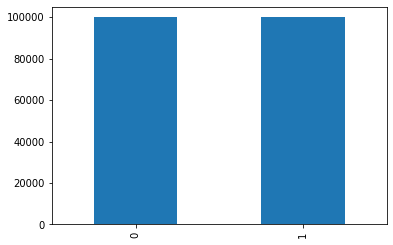

In [10]:
# (3) label 1, 0 막대그래프 그리기
ratings_total['label'].value_counts().plot(kind = 'bar')

In [11]:
print(train.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


- 두 레이블 모두 약 7만 5천개로 50:50 비율을 가짐

## 데이터 정제하기
- 정규 표현식을 사용하여 한글을 제외하고 모두 제거해줍니다. 

In [12]:
# 한글과 공백을 제외하고 모두 제거
# (4) 한글 및 공백 제외한 모든 글자 제거
train['reviews'] = train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['reviews'].replace('', np.nan, inplace=True)

print(train.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


- 테스트 데이터에 대해서도 같은 과정을 거칩니다. 

In [13]:
# (5) 데스트 데이터에 적용하기
# 코드 1 중복 제거
test.drop_duplicates(subset = ['reviews'], inplace=True)
# 코드 2 정규 표현식 수행
test['reviews'] = test['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 코드 3 공백은 Null 값으로 변경
test['reviews'].replace('', np.nan, inplace=True)
# 코드 4 Null 값 제거
test = test.dropna(how='any')

print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 49977


## 토큰화 
- 형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행한다. 

In [14]:
# (6) Mecab 클래스 호출하기
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


- 불용어를 지정하여 필요없는 토큰들을 제거하도록 한다. 

In [15]:
# (7) 불용어 만들기
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

- 훈련 데이터와 테스트 데이터에 대해서 동일한 과정을 거친다. 

In [16]:
train['tokenized'] = train['reviews'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [17]:
test['tokenized'] = test['reviews'].apply(mecab.morphs)
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어와 길이 분포 확인하기
긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.



In [18]:
words_negative = np.hstack(train[train.label == 0]['tokenized'].values)
words_positive = np.hstack(train[train.label == 1]['tokenized'].values)

- Counter()를 사용하여 각 단어에 대한 빈도수를 카운트한다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어 출력

In [20]:
words_negative_count = Counter(words_negative)
print(words_negative_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


'네요', '는데', '안', '않', '너무', '없' 등과 같은 단어들이 부정 리뷰에서 주로 등장합니다. 긍정 리뷰에 대해서도 동일하게 출력해봅시다.

In [21]:
words_positive_count = Counter(words_positive)
print(words_positive_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


'좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장합니다. 두 가지 경우에 대해서 각각 길이 분포를 확인해봅시다.

긍정 리뷰의 평균 길이 : 13.5877381253916
부정 리뷰의 평균 길이 : 17.02948557089084


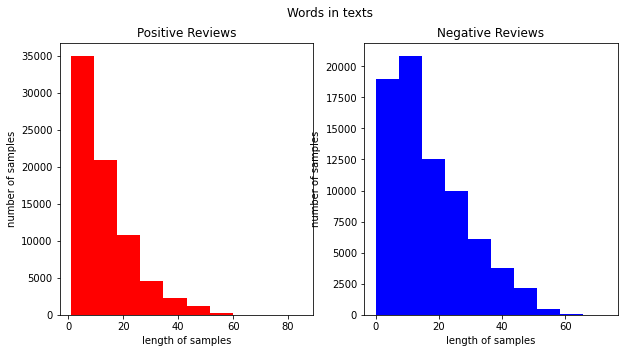

In [22]:
# (8) 긍정 리뷰와 부정 리뷰 히스토그램 작성하기
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train[train['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train[train['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()


- 긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같다. 

In [23]:
X_train = train['tokenized'].values
y_train = train['label'].values
X_test= test['tokenized'].values
y_test = test['label'].values

## 정수 인코딩
- 이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [24]:
# (9) 정수 인코딩 클래스 호출 및 X_train 데이터에 적합하기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [25]:
threshold = 2
total_count = len(tokenizer.word_index) # 단어의 수
rare_count = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_frequency = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_frequency = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_frequency = total_frequency + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_count = rare_count + 1
        rare_frequency = rare_frequency + value

print('단어 집합(vocabulary)의 크기 :',total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_frequency / total_frequency)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935698749320282


단어가 약 40,000개가 존재합니다. 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 45%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%밖에 되지 않습니다. 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [26]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_count - rare_count + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


이제 단어 집합의 크기는 21,787개입니다. 이를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

In [27]:
# (10) 토크나이저 클래스 호출 및 OOV 변환 코드 작성
# 코드 1
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
# 코드 2
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

정수 인코딩이 진행되었는지 확인하고자 X_train과 X_test에 대해서 상위 3개의 샘플만 출력합니다.

In [28]:
print(X_train[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [29]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


## 패딩
이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307521459871541


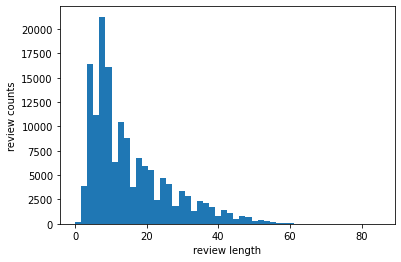

In [30]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('review length')
plt.ylabel('review counts')
plt.show()

리뷰의 최대 길이는 85, 평균 길이는 약 15입니다. 그리고 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.

In [31]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

- 최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.

In [32]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


훈련용 리뷰의 99.99%가 80이하의 길이를 가집니다. 훈련용 리뷰를 길이 80으로 패딩하겠습니다.

In [33]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [34]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2747 - acc: 0.8970
Epoch 00001: val_acc improved from -inf to 0.91876, saving model to best_model.h5
1875/1875 [==============================] - 52s 25ms/step - loss: 0.2747 - acc: 0.8970 - val_loss: 0.2285 - val_acc: 0.9188
Epoch 2/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2156 - acc: 0.9221
Epoch 00002: val_acc improved from 0.91876 to 0.92423, saving model to best_model.h5
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2156 - acc: 0.9221 - val_loss: 0.2132 - val_acc: 0.9242
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1980 - acc: 0.9290
Epoch 00003: val_acc improved from 0.92423 to 0.92557, saving model to best_model.h5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1980 - acc: 0.9290 - val_loss: 0.2038 - val_acc: 0.9256
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1872 - acc: 0.9330
E

In [35]:
sentiment_predict('이 상품 진짜 싫어요... 교환해주세요')

98.66% 확률로 부정 리뷰입니다.


In [36]:
sentiment_predict('이 상품 진짜 좋아여... 강추합니다. ')

98.65% 확률로 긍정 리뷰입니다.
